In [147]:
%load_ext autoreload
%autoreload 2

import os
from itertools import count

import shapefile
import contextily as cx
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import geopandas
import osmnx as ox
import pandas as pd
from tqdm.auto import tqdm
from libpysal.cg import voronoi_frames
import momepy

import shapely
shapely.speedups.disable()

DATA = "data"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [219]:
df = geopandas.read_file("data/TrasyRowerowe/TrasyRowerowe.dbf")
df = df[df['geometry'].notna()]
# df = df[df.TYP != 'łącznik drogowy']
df.head()

,TYP,KIERUNEK,SHAPE_LEN,geometry
0,droga dla pieszych i rowerów,2.0,3.435021,"LINESTRING (6433543.014 5663817.619, 6433546.4..."
1,droga dla pieszych i rowerów,2.0,10.438371,"LINESTRING (6433231.228 5664199.396, 6433231.8..."
2,droga dla pieszych i rowerów,2.0,33.520372,"LINESTRING (6433231.849 5664188.976, 6433231.8..."
3,droga dla rowerów,2.0,161.448060,"LINESTRING (6433238.158 5664508.071, 6433230.9..."
4,droga dla rowerów,2.0,94.881983,"LINESTRING (6433085.661 5664544.599, 6433076.4..."


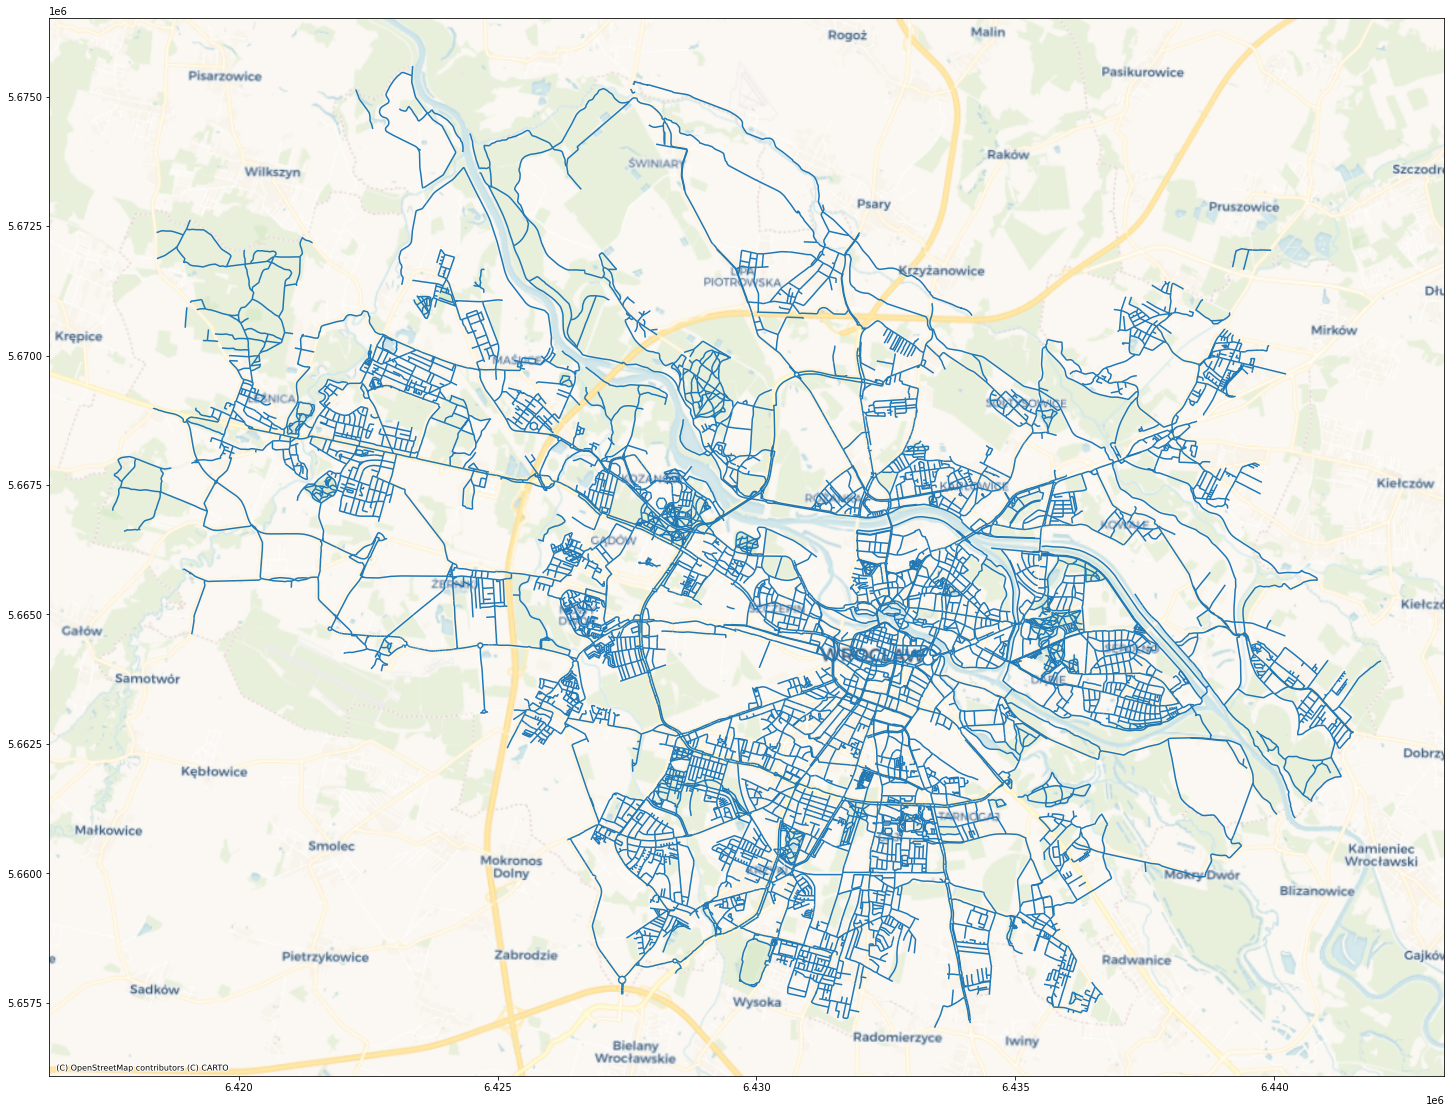

In [220]:
fig = plt.figure(figsize=(25,25))
ax = plt.subplot()
# districts.plot(ax=ax, color='grey', alpha=0.4, edgecolor='k')
df.plot(ax=ax)
cx.add_basemap(ax, crs=df.crs, source=cx.providers.CartoDB.Voyager)

In [223]:
spiw_graph = momepy.gdf_to_nx(df, approach='primal')

In [209]:
nx.write_gpickle(spiw_graph, os.path.join(DATA, "spiw_bike_network.gpickle"))

# save street network as GraphML file to work with later in OSMnx or networkx or gephi
ox.save_graphml(spiw_graph, filepath=os.path.join(DATA, "spiw_bike_network.graphml"))

# save street network as GeoPackage to work with in GIS
ox.save_graph_geopackage(spiw_graph, filepath=os.path.join(DATA, "spiw_bike_network.gpkg"))

KeyError: 'osmid'

Połączenie z Investmap oraz OSM

In [181]:
investmap_gdf = geopandas.read_file(os.path.join(DATA, "investmap.csv"))
investmap_gdf["Longitude"] = investmap_gdf["Longitude"].apply(lambda x: float(x))
investmap_gdf["Latitude"] = investmap_gdf["Latitude"].apply(lambda x: float(x))
investmap_gdf["geometry"] = geopandas.points_from_xy(investmap_gdf["Longitude"], investmap_gdf["Latitude"])
investmap_gdf = investmap_gdf.set_crs(epsg=4326)

In [211]:
bike_gdf = geopandas.read_file(os.path.join(DATA, "peripheral_bike_network.gpkg"))
bike_gdf = bike_gdf.to_crs(epsg=4326)
bike_gdf.head(3)

,osmid,y,x,street_count,highway,ref,geometry
0,95584835,51.083111,17.049513,4,,,POINT (17.04951 51.08311)
1,95584841,51.084699,17.064367,3,,,POINT (17.06437 51.08470)
2,95584850,51.083328,17.035057,4,,,POINT (17.03506 51.08333)


In [243]:
# spiw_gdf = geopandas.read_file(os.path.join(DATA, "peripheral_bike_network.gpkg"))
# spiw_gdf = spiw_gdf.to_crs(epsg=4326)
spiw_gdf = df
spiw_gdf['osmid'] = np.array(spiw_gdf.index, dtype=np.int64) + 1000000
spiw_gdf.head(3)

,TYP,KIERUNEK,SHAPE_LEN,geometry,osmid
0,droga dla pieszych i rowerów,2.0,3.435021,"LINESTRING (6433543.014 5663817.619, 6433546.4...",1000000
1,droga dla pieszych i rowerów,2.0,10.438371,"LINESTRING (6433231.228 5664199.396, 6433231.8...",1000001
2,droga dla pieszych i rowerów,2.0,33.520372,"LINESTRING (6433231.849 5664188.976, 6433231.8...",1000002


In [245]:
full_df = pd.concat([bike_gdf, spiw_gdf], axis=0)
full_df

,osmid,y,x,street_count,highway,ref,geometry,TYP,KIERUNEK,SHAPE_LEN
0,95584835,51.083111,17.049513,4.0,,,POINT (17.04951 51.08311),NaN,NaN,NaN
1,95584841,51.084699,17.064367,3.0,,,POINT (17.06437 51.08470),NaN,NaN,NaN
2,95584850,51.083328,17.035057,4.0,,,POINT (17.03506 51.08333),NaN,NaN,NaN
3,95584852,51.083009,17.053573,4.0,,,POINT (17.05357 51.08301),NaN,NaN,NaN
4,95584855,51.083333,17.034685,4.0,,,POINT (17.03468 51.08333),NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
15801,1015801,NaN,NaN,NaN,NaN,NaN,"LINESTRING (6432873.49570 5664223.35020, 64328...",strefa ruchu uspokojonego 20 i 30 km/h,2.0,4.348127
15802,1015802,NaN,NaN,NaN,NaN,NaN,"LINESTRING (6432881.59880 5664227.58080, 64328...",łącznik drogowy,1.0,6.428841
15803,1015803,NaN,NaN,NaN,NaN,NaN,"LINESTRING (6432700.53060 5664128.42090, 64326...",pas ruchu dla rowerów,1.0,104.677264
15804,1015804,NaN,NaN,NaN,NaN,NaN,"LINESTRING (6432710.12070 5664223.80470, 64327...",możliwość przejazdu,1.0,14.395840


In [225]:
G_spiw = momepy.gdf_to_nx(spiw_gdf, approach='primal')

In [247]:
x_min = full_df.x.min()
x_max = full_df.x.max()
y_min = full_df.y.min()
y_max = full_df.y.max()
x_min, x_max, y_min, y_max

(16.764401, 17.2800532, 50.9481225, 51.2718636)

In [184]:
investmap_gdf = investmap_gdf[(x_min < investmap_gdf.Longitude) & (investmap_gdf.Longitude < x_max) &
                              (y_min < investmap_gdf.Latitude) & (investmap_gdf.Latitude < y_max)]

In [185]:
len(investmap_gdf)

1481

In [186]:
G = nx.read_gpickle(os.path.join(DATA, "peripheral_bike_network.gpickle"))

In [226]:
for n in G.nodes:
    G.nodes[n]["type"]="road_crossing"
    
nx.set_edge_attributes(G, "all_road", "type")

In [227]:
for n in G_spiw.nodes:
    G_spiw.nodes[n]["type"]="bike_crossing"
    
nx.set_edge_attributes(G_spiw, "bike_path", "type")

In [248]:
i = investmap_gdf.to_crs(epsg=2177) #Poland epsg
b = bike_gdf.to_crs(epsg=2177)
s = spiw_gdf.to_crs(epsg=2177)
f = full_df.to_crs(epsg=2177)

In [249]:
Graph = nx.compose(G,G_spiw)

In [250]:
for j, (p_ind, p) in tqdm(enumerate(i.iterrows()), total=i.shape[0]):
    distance=s.distance(p["geometry"])
    idx = distance.idxmin()
    min_d = distance.min()
    node = f'{p["Id"]}_building'
    Graph.add_nodes_from([(node, {'type': 'building', 'name': p["Title"], 'y': p["Latitude"], 'x': p["Longitude"]})])
    Graph.add_edge(full_df.iloc[idx]["osmid"], node, length=min_d, type="closest_crossing")

100%|██████████| 1481/1481 [03:01<00:00,  8.15it/s]


In [252]:
nx.write_gpickle(Graph, os.path.join(DATA, "spiw_peripheral_bike_and_investmap.gpickle"))

Wizualizacja

In [256]:
G = nx.read_gpickle(os.path.join(DATA, "spiw_peripheral_bike_and_investmap.gpickle"))

<AxesSubplot:>

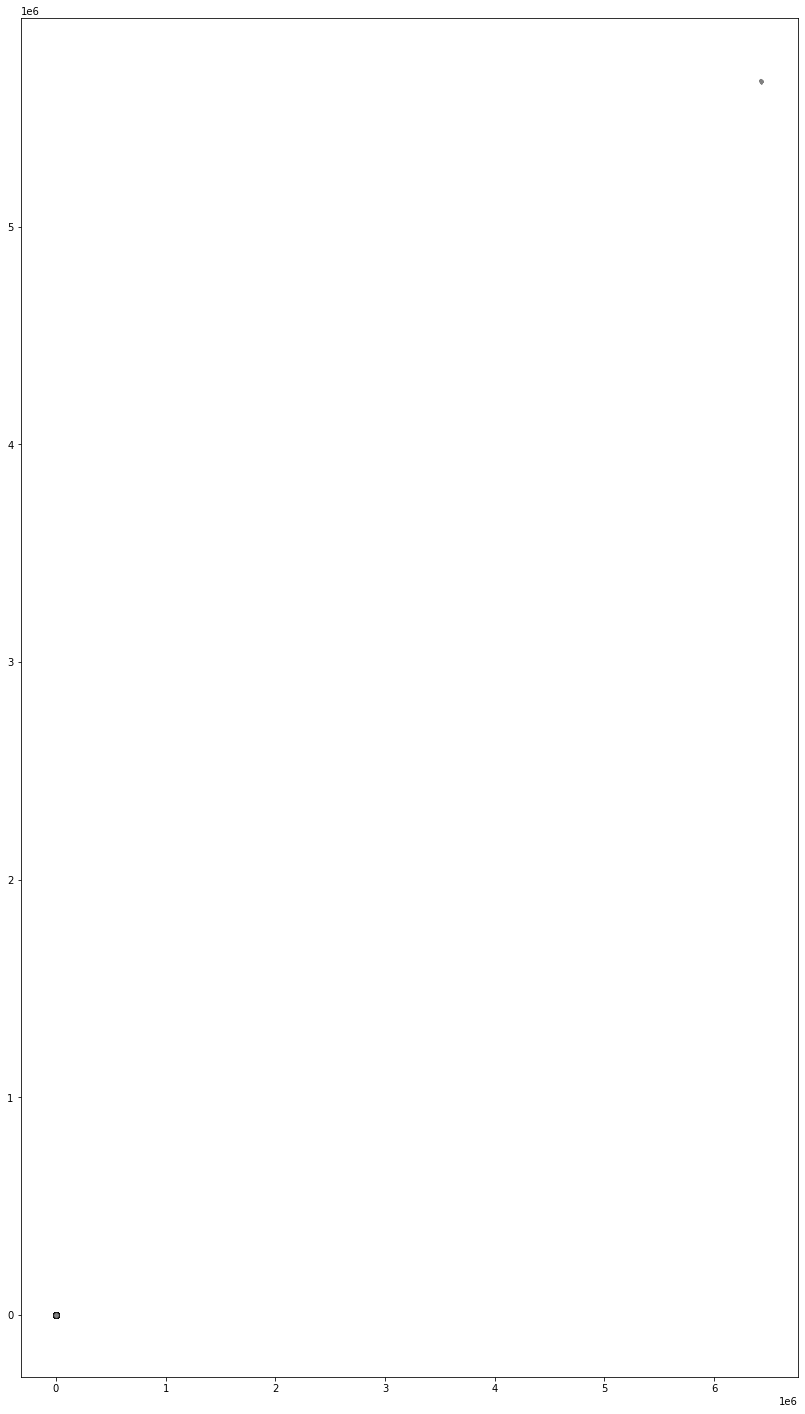

In [277]:
fig = plt.figure(figsize=(25,25))
ax = plt.subplot()
# ax.axis("off")
# nx.draw(
#     G,
#     positions,
#     ax=ax,
#     node_size=node_size,
#     width=.4,
#     node_color=new_colors,
#     edge_color="k",
#     alpha=0.8,
# )
# geopandas.GeoSeries().plot(ax=ax, color='k', alpha=0.5)
# plt.show()
full_df.plot(ax=ax, color='grey', alpha=0.4, edgecolor='k')
# cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.CartoDB.Voyager)

In [254]:
G_nodes, G_streets = ox.graph_to_gdfs(G)

G_nodes = G_nodes.to_crs(epsg=2177)
G_streets = G_streets.to_crs(epsg=2177)

KeyError: 'x'

In [ ]:
fig = plt.figure(figsize=(25,25))
ax = plt.subplot()

G_nodes[G_nodes['type'] == 'crossing'].plot(markersize=0.5, color='green', ax=ax)
G_nodes[G_nodes['type'] == 'building'].plot(markersize=30, color='purple', ax=ax)
G_streets.plot(ax=ax, alpha=0.7, linewidth=0.2, edgecolor='k')
cx.add_basemap(ax=ax, crs=G_nodes.crs.to_string(), source=cx.providers.CartoDB.Voyager)